# 0 Functions demonstration
## 0.1 Trefide
### 0.1.0 Algorithm
Apply TF/TV Penalized Matrix Decomposition (PMD) to factor a (d1*d2)xT column major formatted video into sptial and temporal components.

$Y = AC+B+E$

1. Denoising: removing E
2. Compression: $Y=AC+B$
3. Demixing: factorize Y into A, C, and B
4. Hypotheses:
    * Signal are spatially local
    * Noise is spatially and temporally uncorrelated
    * Signal is low-rank

$R_k = Y_0 - \sum_{i=1}^{k-1}u_i v_i^T$ and finds rank-one approximation $u_k v_k ^T$ such that

$u_k, v_k = \arg\min_{u, v} ||R_k - uv^T||_F$ s.t. $P_{spatial}(u)=||\triangledown_{G} u||\leq c_1^k$, $P_{temproal}(v) = ||D^{(2)}v||_1\leq c_2^k$

$\triangledown_{G}$ is the incidence matrix of the nearest-neighbor pixel-adjaceny graph. $c_1^k$ and $c_2^k$ are decided by its dual problem $\sigma_u^2 d$ and $\sigma_v^2 T$ respectively.

Decision whether a component is kept depends on its roughness $T(u) = P(u)/||u||_1$, and the white noise is below the threshould.


### 0.1.1 Basic Variables
* U : spatial components
* V : temporal components
* K : block ranks
* indices: block indices
### 0.1.2 Functions
* **batch_decompose** : Wrapper for `parallel_factor_patch` which wraps function `factor_patch` with OpenMP directives to parallelize batch processing.
    * d1, d2, t, Y: movie size and raw movie
    * bheight, bwight: block size
    * spatial_thresh, temporal_thresh: thresh for spatial_stat or temporal_stat
    * max_components: max number of components in each patch
    * consec_failures: number of fails that spatial_stat > spatial_thresh or temporal_stat > temporal_thresh
    * max_iters_main, max_iters_init: Loop Until Convergence Of Spatial & Temporal Components, Intialize Components With Power Method Iters
    * tol
    * d_sub, t_sub: spatial downsampling factor (on blocks), temporal downsampling factor
* **batch_recompose** : Reconstruct A Denoised Movie from matrice `U`, `V` $Y_d = \sum_{k}^K U_k*V_k$
* **overlapping_batch_recompose** : 4x batch denoiser
* **overlapping_batch_recompose** : Reconstruct A Denoised Movie from 4x batch denoiser 
* **determine_thresholds** : Get spatial and temporal threshoulds from simulated noisy movie with same movie dimensionalities


In [1]:
# General Dependencies
import os
import numpy as np
# Denoising dependencies
from trefide.pmd import batch_decompose, \
                        batch_recompose, \
                        overlapping_batch_decompose, \
                        overlapping_batch_recompose, \
                        determine_thresholds
from trefide.reformat import overlapping_component_reformat
# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import write_mpl

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import seaborn as sns
# sns.set(font_scale=1.5)
%matplotlib inline

import sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1.1 Load data

In [2]:
imgStack = np.load('tmpData/imgDMotion.npy')
Y = np.asarray(imgStack)
Y = Y.transpose([1,2,0])

## 1.2 Detrend

In [3]:
# from spatialDenoising.preprocess import detrend # default order = 3
# stim = None
# disc = None
# Y_detr, trend, _, _ = detrend(Y, stim, disc) # this could be speed up using mp....
# np.save('tmpData/Y_detr', Y_detr)
# np.save('tmpData/Y_trend', trend)

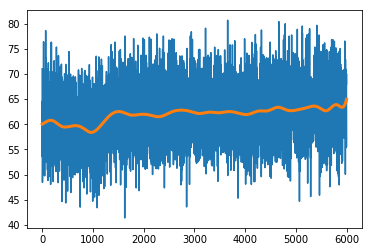

In [4]:
Y_detr = np.load('tmpData/Y_detr.npy')
trend = np.load('tmpData/Y_trend.npy')
# crop_x = (105, 115)
# crop_y = (245, 255)
plt.plot(Y[125, 246, :])
plt.plot(trend[125, 246, :], linewidth=3)
plt.show()

## 1.3 Set params

In [5]:
mov = np.asarray(Y_detr,order='C',dtype=np.float64)
mov = (mov - mov.mean(axis=-1)[:, :, np.newaxis])/mov.std(axis=-1)[:, :, np.newaxis]
fov_height, fov_width, num_frames = mov.shape

# Maximum of rank 100 blocks (safeguard to terminate early if this is hit)
max_components = 100
# Enable Decimation 
max_iters_main = 100
max_iters_init = 40
d_sub=1
t_sub=1
# Defaults
consec_failures = 10
tol = 0.0005
# Set Blocksize Parameters
block_height = 12 #block dims
block_width = 12 #block dims
overlapping = True

## 1.4 Denoising movie (low-rank approximation)

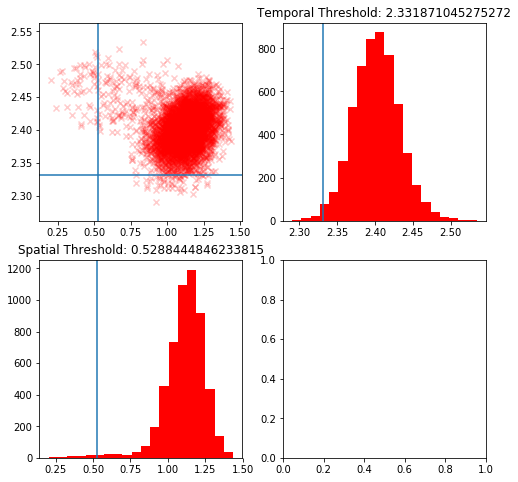

In [6]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames), 
                                                       (block_height, block_width), 
                                                       consec_failures, max_iters_main, max_iters_init, tol, 
                                                       d_sub, t_sub, 1, True)

In [7]:
# Blockwise Parallel, Single Tiling
if not overlapping:    
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)    
# Blockwise Parallel, 4x Overlapping Tiling
else:   
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub=d_sub, t_sub=t_sub)

## 1.5 Reconstruct Denoised Video

In [8]:
# Single Tiling (No need for reqweighting)
if not overlapping: 
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
# Overlapping Tilings With Reweighting
else:  
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

## 1.6 Diagnostics
### 1.6.1 Pixel-wise Ranks

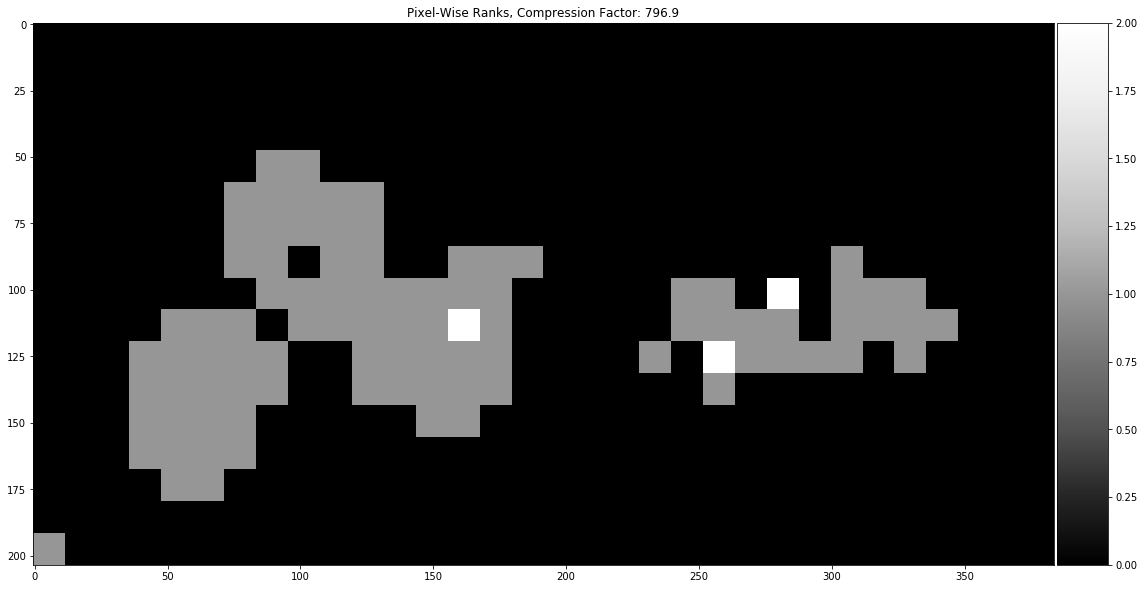

In [9]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### 1.6.2 Correlation Images
Adding some amount noise to avoid zeros generating fake strong correlations.

Local correlation:  range [-3.0e-02 4.5e-01]
Local correlation:  range [-9.9e-01 1.0e+00]
Local correlation:  range [-4.8e-02 3.8e-01]


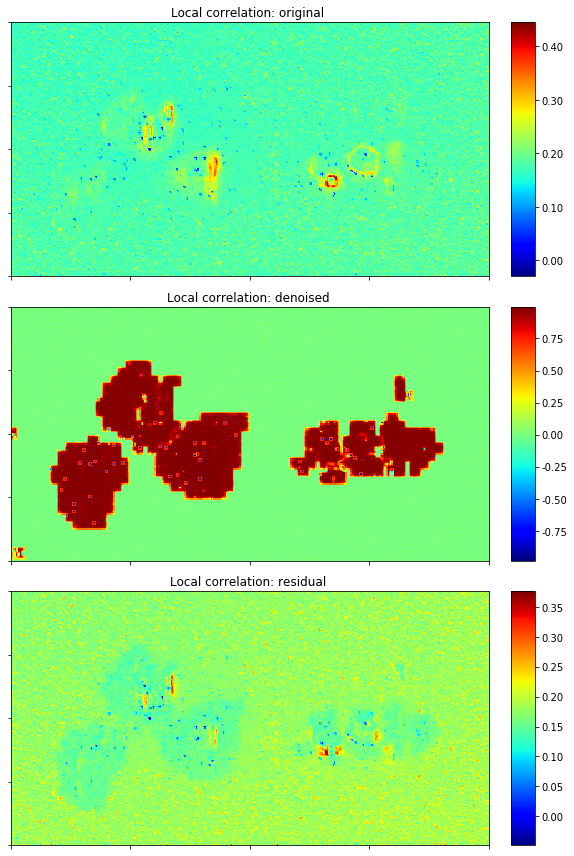

In [10]:
comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01], 
                plot_orientation="horizontal")

### 1.6.3 Render Videos & Residual

In [11]:
from trefide.extras.util_plot import correlation_pnr
Cn, _ = correlation_pnr(mov-mov_denoised, gSig=None, remove_small_val=False, remove_small_val_th=3, center_psf=False)

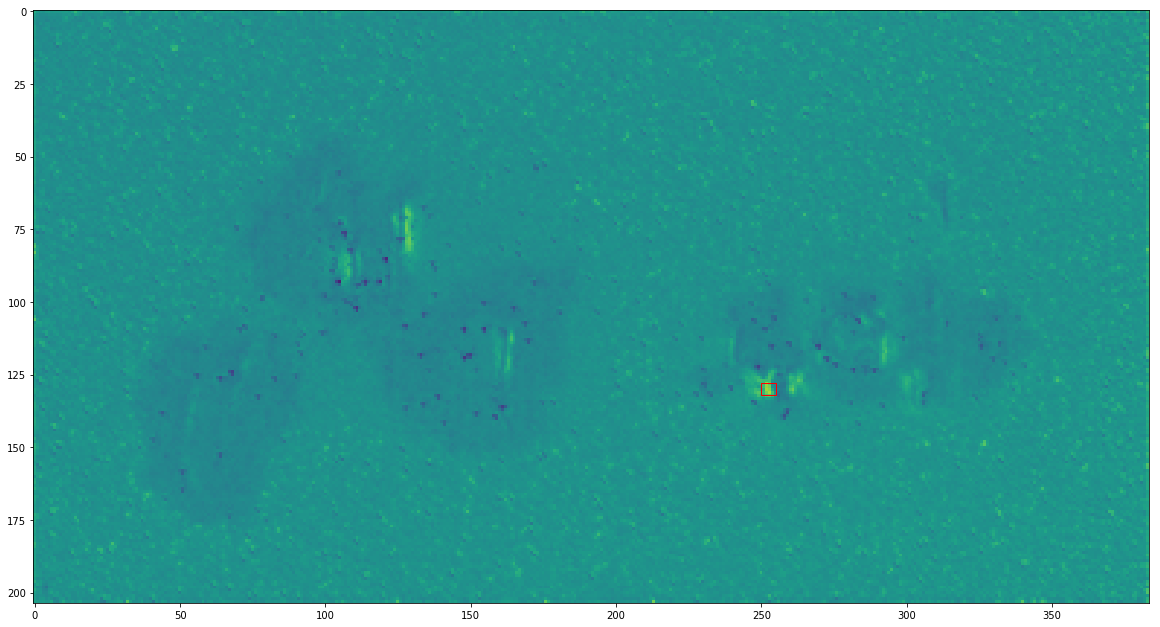

In [12]:
crop_x = (128, 132)
crop_y = (250, 255)
# crop_x = (130, 131)
# crop_y = (250, 251)
# crop_x = (105, 115)
# crop_y = (245, 255)
mask = np.zeros(Cn.shape)
mask[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]] = 1

fig,ax = plt.subplots(1,figsize=(20,15))
ax.imshow(Cn, vmax=0.45, vmin=-0.1)
# ax.imshow(mask, alpha=0.2)
rect = patches.Rectangle((crop_y[0],crop_x[0]),crop_y[1]-crop_y[0],crop_x[1]-crop_x[0],linewidth=1,edgecolor='r',
                         facecolor='none')
ax.add_patch(rect)
plt.show()

In [13]:
cropRaw = mov[mask==1, :]
cropSDN = mov_denoised[mask==1, :]

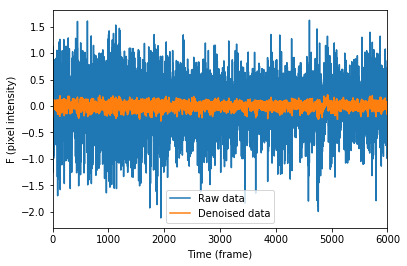

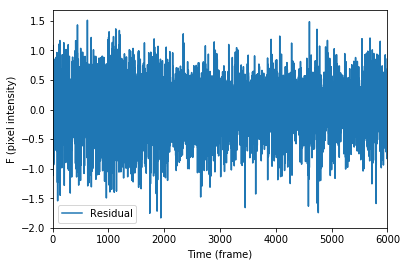

In [14]:
plt.plot(cropRaw.mean(axis=0), label='Raw data')
plt.plot(cropSDN.mean(axis=0), label='Denoised data')
plt.ylabel('F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.xlim([0, 6000])
plt.legend()
plt.show()
plt.plot(cropRaw.mean(axis=0)-cropSDN.mean(axis=0), label='Residual')
plt.ylabel('F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.xlim([0, 6000])
plt.legend()
plt.show()

In [15]:
Cn_, _ = correlation_pnr(mov, gSig=None, remove_small_val=False, remove_small_val_th=3, center_psf=False)

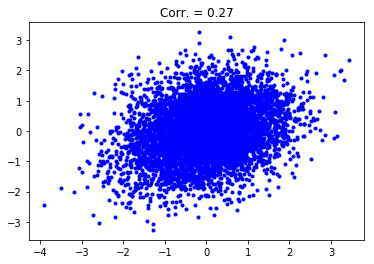

0.37612548
0.44504705


In [16]:
mov_r = mov - mov_denoised
loc = [131, 253]
plt.plot(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :], '.b')
# plt.plot(mov[loc[0], loc[1], :], mov[loc[0]+1, loc[1]+1, :], '.r')
plt.title('Corr. = %0.2f'%(np.corrcoef(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :])[0,1]))
plt.show()
print(Cn[loc[0], loc[1]])
print(Cn_[loc[0], loc[1]])

In [17]:
# write_mpl([mov, mov_denoised, mov-mov_denoised], 'denoised_mov', fr=30, horizontal=True, titles=None)

### 1.6.4 Save denoised movie

In [18]:
# U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
#                                       block_height, block_width,
#                                       spatial_components,
#                                       temporal_components,
#                                       block_ranks,
#                                       block_indices,
#                                       block_weights)

In [19]:
# np.savez(os.path.join(ext, "demo_results.npz"), U, V)